# Libraries

In [1]:
import cv2
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.patches as patches


# Data Preprocess
In this section, we'll load and preprocess satellite images to prepare them for a machine learning model aimed at detecting planes. The process involves organizing images, converting their color schemes, and splitting the dataset for model training and evaluation.


In [2]:
# Assuming basepath is correctly set to point to the directory containing the images
basepath = "./data/planesnet/planesnet/"

# Placeholder lists for images and labels
images = []
labels = []

# Pattern to match all .png files
image_paths = glob(os.path.join(basepath, "*.png"))

# Process each image file
for img_path in image_paths:
    # Read the image
    img = cv2.imread(img_path)
    
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Normalize pixel values
    img = img / 255.0
    
    # Append image to the list
    images.append(img)
    
    # Extract label from filename (0 or 1 prefix indicates the class)
    label = int(os.path.basename(img_path)[0])
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)  # Adjusted for NumPy compatibility

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_validation.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")


Training set: 22400 images
Validation set: 6432 images
Test set: 3168 images


# 3 - Define the Convolutional Neural Network

In [4]:
# Define the Neural Network
model = Sequential()
n_classes = 2

model.add(Conv2D(32, (3, 3), activation='linear', input_shape = (20, 20, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='softmax'))

# 4 - Compile and fit the model

In [5]:
# Compile and fit the NN 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint("plane_detection.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, batch_size=16, epochs=40, verbose=1, validation_data=(X_validation, y_validation), callbacks=[checkpoint])

Epoch 1/40
1398/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8002 - loss: 0.4486
Epoch 1: val_accuracy improved from -inf to 0.92180, saving model to plane_detection.keras
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8004 - loss: 0.4484 - val_accuracy: 0.9218 - val_loss: 0.1944
Epoch 2/40
1399/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9065 - loss: 0.2315
Epoch 2: val_accuracy did not improve from 0.92180
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9065 - loss: 0.2315 - val_accuracy: 0.8910 - val_loss: 0.2493
Epoch 3/40
1397/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9215 - loss: 0.2015
Epoch 3: val_accuracy did not improve from 0.92180
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9216 - loss: 0.2015 - val_accuracy: 0.8478 - val_loss: 0.3225
Epoch 4/40
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9367 - loss: 0.1687
Epoch 4: val_accuracy did not improve from 0.92180
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step

# 5 - Evaluate the model

In [6]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9912 - loss: 0.0254
Test Loss: 0.030098436400294304
Test Accuracy: 0.9886363744735718


# 6 - Show accuracy and loss plots of the model

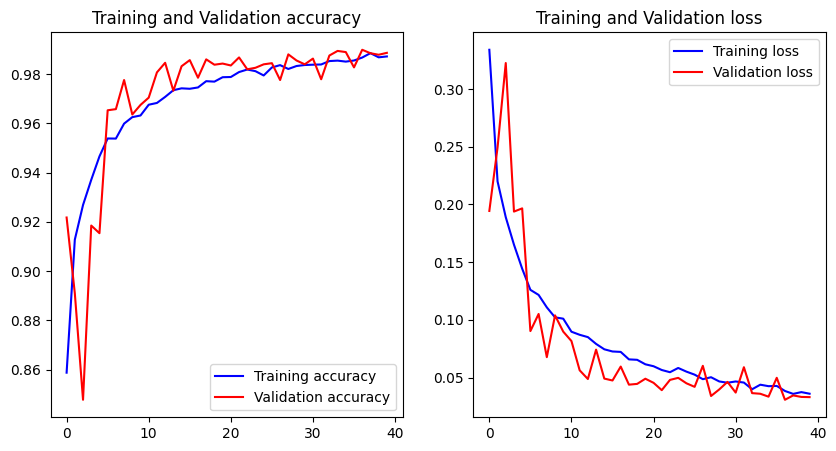

In [7]:
# Show accuracy and loss plots of the model 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# 7 - Predict

In [9]:
# Obtain predictions
predicted_class = model.predict(X_test)
print(predicted_class.shape)
print(y_test.shape)
predicted_class_probability = np.max(predicted_class, axis=1)*100
predicted_class = np.argmax(predicted_class, axis=1)
true_class = np.argmax(y_test, axis=1)

correct = []
incorrect = []

for i in range(len(predicted_class)):
    if predicted_class[i] == true_class[i]:
        correct.append(i)
    else:
        incorrect.append(i)

print('Correct predictions: ', len(correct))        
print('Incorrect predictions: ', len(incorrect))  

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(3168, 2)
(3168, 2)
Correct predictions:  3132
Incorrect predictions:  36


# 8 - Show CORRECT predictions

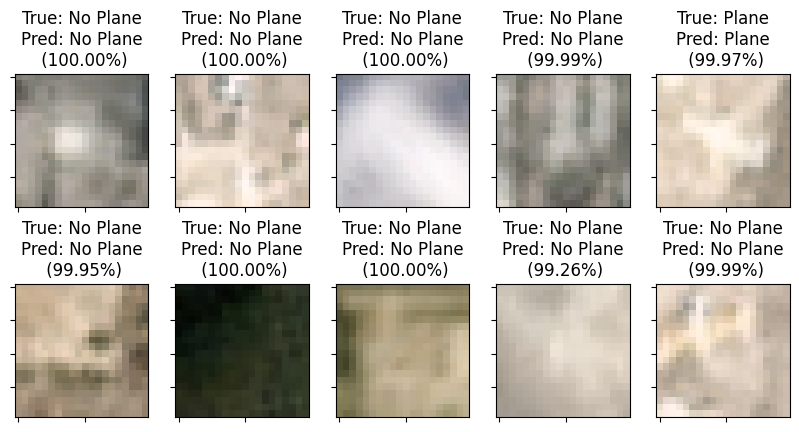

In [18]:
random.shuffle(correct)
random.shuffle(incorrect)
text_labels = ['No Plane', 'Plane']

# Show some CORRECT PREDICTIONS
n_rows = 2
n_cols = 5

plt.figure(figsize=(10, 5))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[correct[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[correct[i]]]) + 
              '\nPred: ' + str(text_labels[predicted_class[correct[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[correct[i]])

# 9 - Show INCORRECT predictions

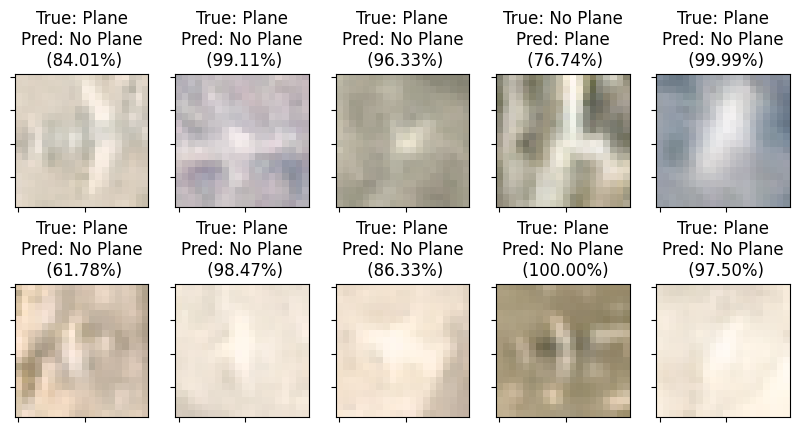

In [19]:
# Show some INCORRECT PREDICTIONS
n_rows = 2
n_cols = 5

plt.figure(figsize=(10, 5))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[incorrect[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[incorrect[i]]]) + 
              '\nPred: ' + str(text_labels[predicted_class[incorrect[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[incorrect[i]])

# 10 - Show Confussion Matrix

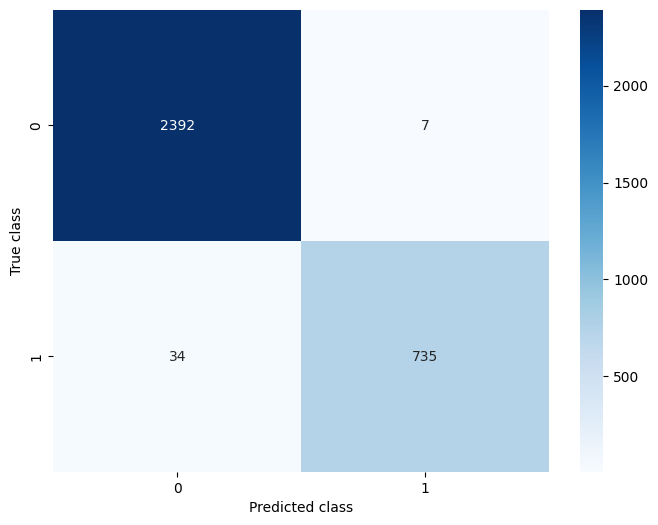

In [24]:
# Show confussion Matrix
cm = confusion_matrix(true_class, predicted_class)
plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

# 11 - Identify planes on scene

Step 0 of 104
Step 1 of 104
Step 2 of 104
Step 3 of 104
Step 4 of 104
Step 5 of 104
Step 6 of 104
Step 7 of 104
Step 8 of 104
Step 9 of 104
Step 10 of 104
Step 11 of 104
Step 12 of 104
Step 13 of 104
Step 14 of 104
Step 15 of 104
Step 16 of 104
Step 17 of 104
Step 18 of 104
Step 19 of 104
Step 20 of 104
Step 21 of 104
Step 22 of 104
Step 23 of 104
Step 24 of 104
Step 25 of 104
Step 26 of 104
Step 27 of 104
Step 28 of 104
Step 29 of 104
Step 30 of 104
Step 31 of 104
Step 32 of 104
Step 33 of 104
Step 34 of 104
Step 35 of 104
Step 36 of 104
Step 37 of 104
Step 38 of 104
Step 39 of 104
Step 40 of 104
Step 41 of 104
Step 42 of 104
Step 43 of 104
Step 44 of 104
Step 45 of 104
Step 46 of 104
Step 47 of 104
Step 48 of 104
Step 49 of 104
Step 50 of 104
Step 51 of 104
Step 52 of 104
Step 53 of 104
Step 54 of 104
Step 55 of 104
Step 56 of 104
Step 57 of 104
Step 58 of 104
Step 59 of 104
Step 60 of 104
Step 61 of 104
Step 62 of 104
Step 63 of 104
Step 64 of 104
Step 65 of 104
Step 66 of 104
Step 

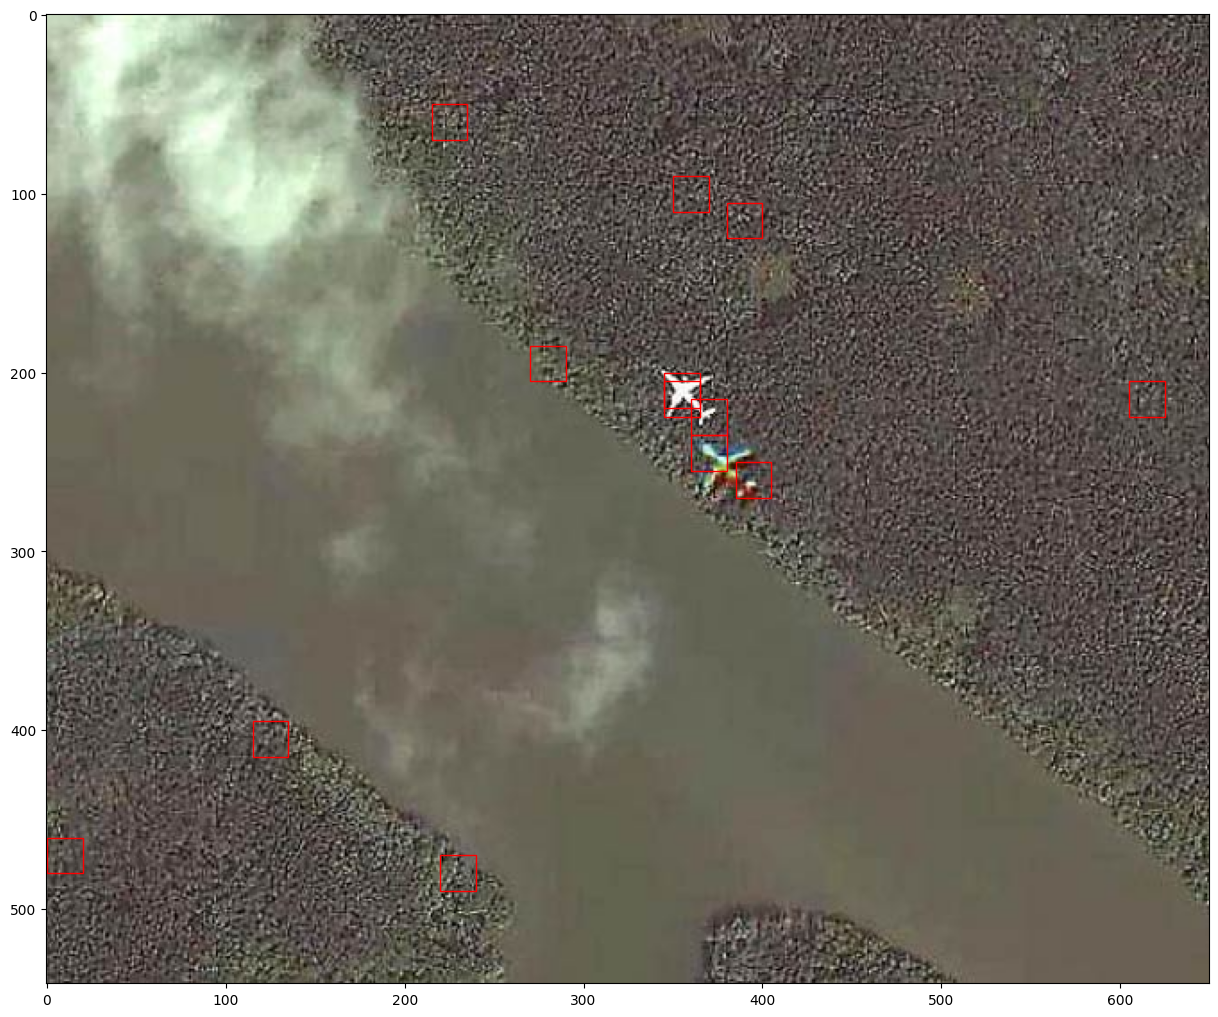

In [10]:
# Load and show scene
basepath = "./data/scenes/scenes"

scene_list = glob(os.path.join(basepath, "*5*"))
scene_file = scene_list[0]

img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)

stride = 5
for h in range(0, height-20, stride):
    print("Step", int(h/stride), "of", int((height-20)/stride))
    
    for w in range(0, width-20, stride):  
        img_box = []
        img_box.append(img[h:h+20, w:w+20])
        img_box = np.array(img_box, dtype=np.int64)
        prediction = model.predict(img_box, verbose=False)
        prediction = np.argmax(prediction)
        
        if prediction == 1:
            ax.add_patch(patches.Rectangle((w, h), 20, 20, edgecolor='r', facecolor='none'))
            
plt.show()